In [1]:
import pandas as pd
#from google.colab import drive
import os
from pathlib import Path

# 1. Mount Google Drive
#drive.mount('/content/drive')


In [3]:
import pandas as pd

def clean_patient_csv(filepath, sep=";"):
    """
    Clean a single patient CSV:
    - Parse time & sort
    - Drop duplicate timestamps
    - Fix numeric data types
    - Remove impossible negative values
    - Flag but don't drop outliers (glucose, heart rate)

    Returns a cleaned pandas DataFrame.
    """  

    # Load file
    df = pd.read_csv(filepath, sep=sep)
    #usha
    # 1. Parse datetime and sort
    df['time'] = pd.to_datetime(df['time'], errors='coerce')
    df = df.drop_duplicates(subset=['time']).sort_values('time').reset_index(drop=True)
    #Lakshmi
    # 2. Fix numeric data types
    #This part of the code checks for different columns like glucose and heart_rate and rounds the values to whole numbers. 
    #For other things like bolus_volume_delivered,basal_rate and calories it keeps a few decimal places so the data stays accurate. 
    if 'glucose' in df.columns:
        df['glucose'] = df['glucose'].round().astype('Int64')
    if 'heart_rate' in df.columns:
        df['heart_rate'] = df['heart_rate'].round().astype('Int64')
    if 'calories' in df.columns:
        df['calories'] = df['calories'].round(1)
    if 'steps' in df.columns:
        df['steps'] = df['steps'].round().astype('Int64')
    if 'basal_rate' in df.columns:
        df['basal_rate'] = df['basal_rate'].round(3)
    if 'bolus_volume_delivered' in df.columns:
        df['bolus_volume_delivered'] = df['bolus_volume_delivered'].round(1)
    if 'carb_input' in df.columns:
        df['carb_input'] = df['carb_input'].round().astype('Int64')
    #Gauri
    # 3. Remove impossible negatives
    for col in ['glucose','calories','steps','basal_rate','bolus_volume_delivered','carb_input','heart_rate']:
        if col in df.columns:
            df.loc[df[col] < 0, col] = df.loc[df[col] < 0, col].abs()# convert to positive based on the other columns values/entries
    #Joshna
    # 4. Flag outliers (keep them for analysis)
    if 'glucose' in df.columns:
        df['flag_glucose_outlier'] = (df['glucose'] < 40) | (df['glucose'] > 400)
    if 'heart_rate' in df.columns:
        df['flag_hr_outlier'] = (df['heart_rate'] < 30) | (df['heart_rate'] > 220)
        # Basal rate flags
    if 'basal_rate' in df.columns:
        df['flag_basal_outlier'] = (df['basal_rate'] < 0) | (df['basal_rate'] > 5)
      # Bolus volume flags
    if 'bolus_volume_delivered' in df.columns:
        df['flag_bolus_outlier'] = (df['bolus_volume_delivered'] < 0) | (df['bolus_volume_delivered'] > 25)

    return df


In [10]:
from tabulate import tabulate
# Folder containing your patient CSVs
folder = Path("HUPA-UC Diabetes Dataset")
summary=[]
# Loop through all files starting with "HUP"
for f in folder.glob("HUP*.csv"):
    print(f"\n=== Processing {f.name} ===")

    # Clean the file
    df_clean = clean_patient_csv(f)
    outlier_counts = {
        "file": f.name,
        "glucose_outliers": df_clean['flag_glucose_outlier'].sum(),
        "hr_outliers": df_clean['flag_hr_outlier'].sum(),
        "basal_outliers": df_clean['flag_basal_outlier'].sum(),
        "bolus_outliers": df_clean['flag_bolus_outlier'].sum(),
        "rows": len(df_clean)
    }
    summary.append(outlier_counts)

    summary_df = pd.DataFrame(summary)
    # Print summary info
    print(df_clean.info())
    print(df_clean['basal_rate'].max())
    print(df_clean['bolus_volume_delivered'].max())
    print(df_clean['flag_glucose_outlier'].value_counts())
    print(df_clean['flag_hr_outlier'].value_counts())
    # Check counts
    print(df_clean['flag_basal_outlier'].value_counts())
    print(df_clean['flag_bolus_outlier'].value_counts())
    print(tabulate(df_clean.head(), headers='keys', tablefmt='psql'))


=== Processing HUPA0023P.csv ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3919 entries, 0 to 3918
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   time                    3919 non-null   datetime64[ns]
 1   glucose                 3919 non-null   Int64         
 2   calories                3919 non-null   float64       
 3   heart_rate              3919 non-null   Int64         
 4   steps                   3919 non-null   Int64         
 5   basal_rate              3919 non-null   float64       
 6   bolus_volume_delivered  3919 non-null   float64       
 7   carb_input              3919 non-null   Int64         
 8   flag_glucose_outlier    3919 non-null   boolean       
 9   flag_hr_outlier         3919 non-null   boolean       
 10  flag_basal_outlier      3919 non-null   bool          
 11  flag_bolus_outlier      3919 non-null   bool          
dtypes: Int64(4), b

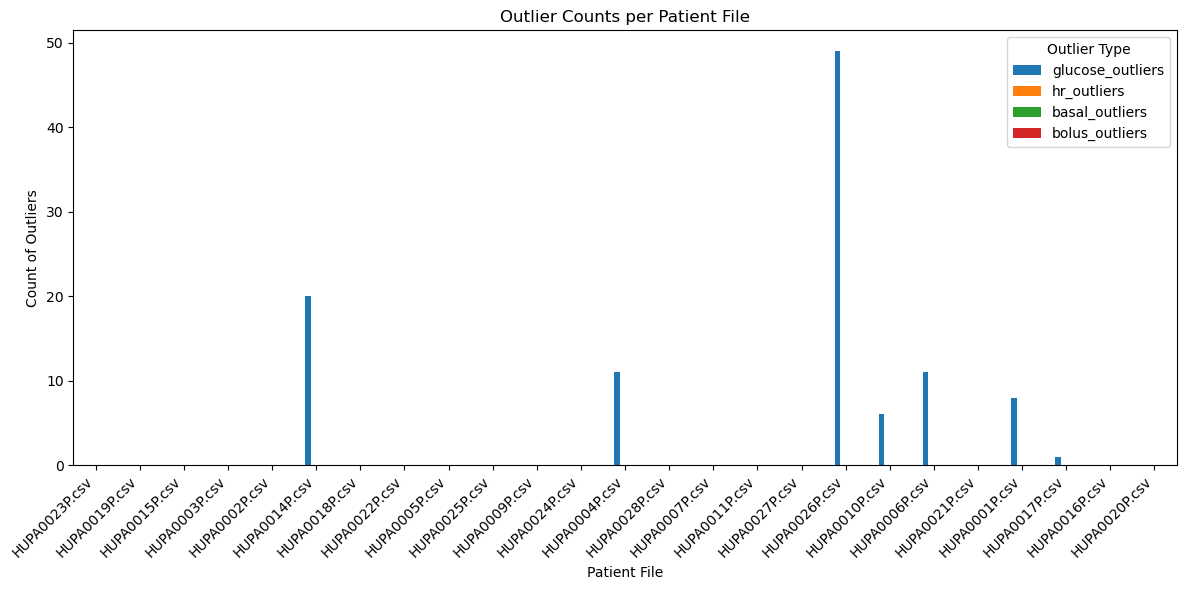

In [11]:
import matplotlib.pyplot as plt

summary_df.set_index("file")[["glucose_outliers","hr_outliers",
                              "basal_outliers","bolus_outliers"]].plot(
    kind="bar", figsize=(12,6), stacked=False
)

plt.title("Outlier Counts per Patient File")
plt.ylabel("Count of Outliers")
plt.xlabel("Patient File")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Outlier Type")
plt.tight_layout()
plt.show()
